In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if not torch.backends.mps.is_available():
    device = torch.device('cpu')
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

model_path = "r18_best.pth"

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 128, num_blocks[3], stride=2)
        self.linear = nn.Linear(8960 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [2]:
net = ResNet18()

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
total_params

789498

In [3]:
from util import load_data_from_split
split_songs = False
train_loader, val_loader, test_loader = load_data_from_split(resize_images=False, batch_size=10, split_songs=split_songs)

# print(len(train_loader.dataset))
# print(len(val_loader.dataset))
# print(len(test_loader.dataset))

/Users/steven/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from util import train_loop
import numpy as np
import random

net = ResNet18()
num_epochs = 20
criterion = nn.CrossEntropyLoss() # loss function

optimizer = optim.SGD(net.parameters(), lr=5e-3, momentum=0, weight_decay=1e-5)
# optimizer = optim.Adam(net.parameters(), lr=5e-4, weight_decay=1e-5)

scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=(num_epochs/2)*len(train_loader), step_size_down=(num_epochs/2)*len(train_loader), mode='triangular')
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=1, cooldown=0, min_lr=1e-5)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

training_losses, validation_losses = train_loop(
    net=net,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    model_path=model_path,
    split_songs=split_songs,
    num_epochs=num_epochs,
    optimizer=optimizer,
    scheduler=scheduler
)

Epoch 1 | LR: 1.00e-05 -> 1.09e-04 | Train Loss: 2.317 | Val Loss: 2.182 | Val Acc: 25.00%


KeyboardInterrupt: 

In [9]:
from util import test_model, test_model_aggregate

net = ResNet18()
net.to(device)

net.load_state_dict(torch.load(f"models/{model_path}"))

test_accuracy, test_loss = test_model(net, test_loader, device, criterion)

results_str = f"Test Accuracy | Idv: {test_accuracy:.2f}%"
if(split_songs):
    test_accuracy_agg = test_model_aggregate(net, test_loader, device)
    results_str += f", Agg: {test_accuracy_agg:.2f}%"

print(results_str)

Test Accuracy | Idv: 73.40%, Agg: 79.00%


[1.840080985885687, 1.3800553617922027, 1.118700201356217, 0.9559650904171458, 0.7659195594685397, 0.6410956480989095, 0.5144393296984581, 0.4079447351232898, 0.32677917832856035, 0.28995226739552593, 0.17567643447946968, 0.10258519930577953, 0.0514238145774203, 0.022564484418290568, 0.009041516633623585, 0.007048810160592389, 0.004398045484346684, 0.003694675737285715, 0.003294941399004809, 0.0031481648824847617] [1.4586957049369813, 2.021482861042023, 2.5594801872968675, 1.201768627166748, 1.7152819608151912, 1.5760417845845223, 1.1721228248998523, 1.188940442055464, 1.2825209718942643, 1.7575456930696964, 1.2857861786335707, 1.1650832037720829, 1.530006764382124, 1.0977360485540704, 1.1173646560870112, 1.078978363214992, 1.0820885695517064, 1.082055844189599, 1.0874381227418781, 1.0791588997468353]


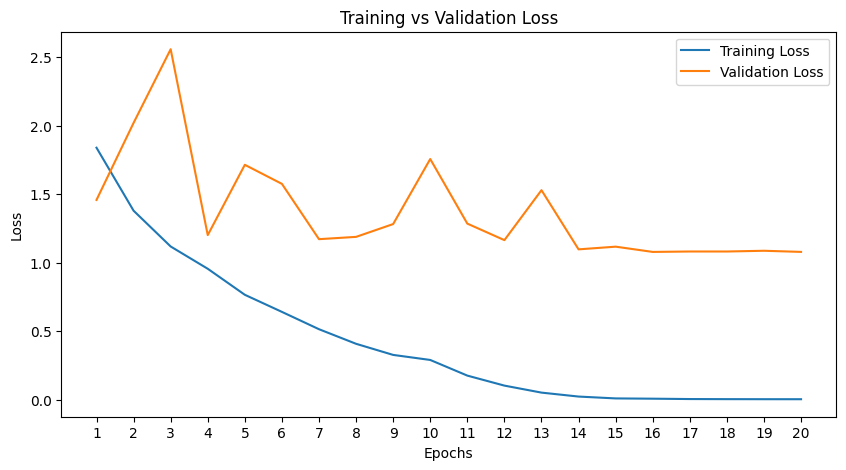

In [7]:
from util import plot_loss
print(training_losses, validation_losses)
plot_loss(training_losses, validation_losses)